# Adult Salary with Logistic Regression

In [49]:
library(dplyr)
# Load the Data
adult <- read.csv('adult_sal.csv')
adult <- adult %>% mutate_if(is.character,as.factor)
head(adult)
str(adult)


,X,age,type_employer,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country,income
,<int>,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
1,1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


'data.frame':	32561 obs. of  16 variables:
 $ X            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ age          : int  39 50 38 53 28 37 49 52 31 42 ...
 $ type_employer: Factor w/ 9 levels "?","Federal-gov",..: 8 7 5 5 5 5 5 7 5 5 ...
 $ fnlwgt       : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education    : Factor w/ 16 levels "10th","11th",..: 10 10 12 2 10 13 7 12 13 10 ...
 $ education_num: int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital      : Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 5 3 1 3 3 3 4 3 5 3 ...
 $ occupation   : Factor w/ 15 levels "?","Adm-clerical",..: 2 5 7 7 11 5 9 5 11 5 ...
 $ relationship : Factor w/ 6 levels "Husband","Not-in-family",..: 2 1 2 1 6 6 2 1 2 1 ...
 $ race         : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 5 3 3 5 3 5 5 5 ...
 $ sex          : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 1 1 2 1 2 ...
 $ capital_gain : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss : int  0 0 0 0 0 0 0 0 

## Cleaning Data

In [50]:
# Drop index
adult <- select(adult, -X)

# Reduce the number of factors in type_employer column
table(adult$type_employer)


               ?      Federal-gov        Local-gov     Never-worked 
            1836              960             2093                7 
         Private     Self-emp-inc Self-emp-not-inc        State-gov 
           22696             1116             2541             1298 
     Without-pay 
              14 

#### Reduce Category of employment type

In [51]:
# Combine the least two category into unemployed column
combine_emp<- function(type){
  out <- type
  if(type == 'Never-worked' || type == 'Without-pay'){
    out <- 'Unemployed'
  } else if( type == 'Local-gov' || type == 'State-gov'){
    out <- 'SL-gov'
  } else if( type == 'Self-emp-inc'|| type =='Self-emp-not-inc'){
    out <- 'self-emp' 
  }
  return (out)
}
adult$type_employer <- sapply(as.character(adult$type_employer), combine_emp) %>% as.factor()

table(adult$type_employer)


          ? Federal-gov     Private    self-emp      SL-gov  Unemployed 
       1836         960       22696        3657        3391          21 

#### Reduce Category of Marital Status

In [52]:
combine_marital<- function(type){
  out <- type
  if(type == 'Married-AF-spouse' || type == 'Married-civ-spouse' || type == 'Married-spouse-absent'){
    out <- 'Married'
  } else if( type == 'Divorced' || type == 'Separated' || type == 'Widowed'){
    out <- 'Not-Married'
  } else {
    out <- 'Never-Married'
  }
}

adult$marital <- sapply(as.character(adult$marital), combine_marital) %>% as.factor()

table(adult$marital)


      Married Never-Married   Not-Married 
        15417         10683          6461 

#### Reduce Category of countries

In [53]:
adult <- adult %>%
  mutate(country = case_when(
    country %in% c("United-States", "Canada", "Mexico", "Outlying-US(Guam-USVI-etc)") ~ "North.America",
    country %in% c("Columbia", "Cuba", "Dominican-Republic", "Ecuador", "El-Salvador", "Guatemala",
                   "Haiti", "Honduras", "Jamaica", "Nicaragua", "Peru", "Puerto-Rico", "Trinadad&Tobago") ~ "Central.South America",
    country %in% c("England", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", 
                   "Poland", "Portugal", "Scotland", "Yugoslavia", "Holand-Netherlands") ~ "Europe",
    country %in% c("Cambodia", "China", "Hong", "India", "Iran", "Japan", "Laos", "Philippines",
                   "Taiwan", "Thailand", "Vietnam") ~ "Asia",
    country %in% c("Iran","South","?") ~ "Other",
    TRUE ~ "Other"  # Default catch-all category
  )) %>%
  mutate(country = as.factor(country))
table(adult$country)


                 Asia Central.South America                Europe 
                  671                   758                   521 
        North.America                 Other 
                29948                   663 

### Missing Data

In [54]:
library(Amelia)

adult[] <- lapply(adult, function(col){
  if(is.factor(col)){
    col <- as.character(col)
  }
  col[col == '?'] <- NA
  if(is.character(col)){
    col<-as.factor(col)
  }
  return (col)
})

table(adult$type_employer)


Federal-gov     Private    self-emp      SL-gov  Unemployed 
        960       22696        3657        3391          21 

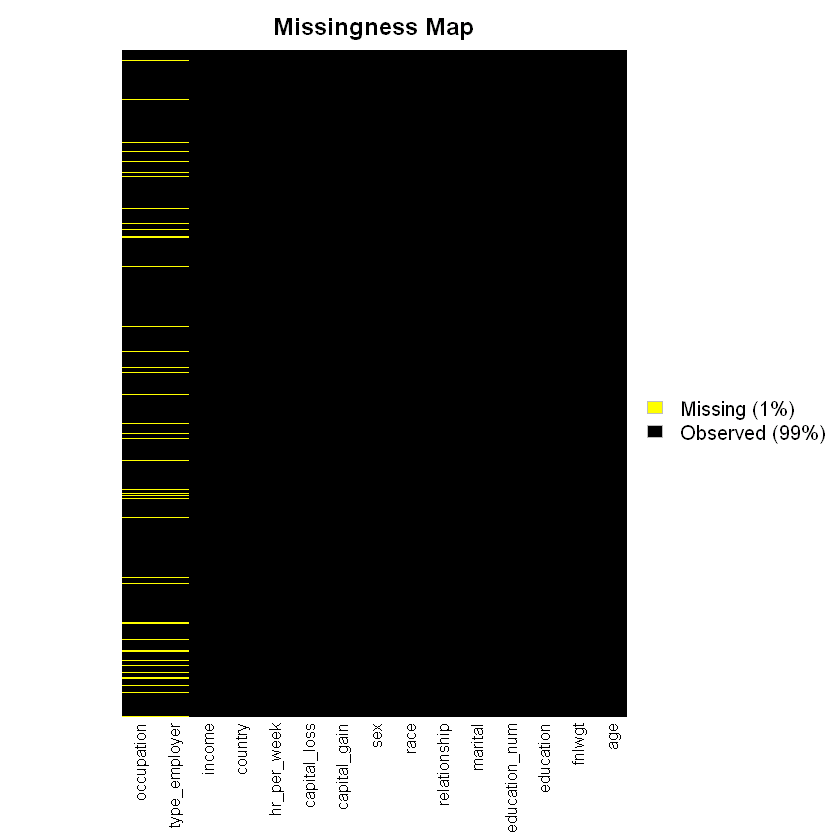

In [55]:
missmap(adult, y.at=c(1), y.labels=c(''), col = c('yellow','black'))

#### Delete all NA rows

'data.frame':	30718 obs. of  15 variables:
 $ age          : int  39 50 38 53 28 37 49 52 31 42 ...
 $ type_employer: Factor w/ 5 levels "Federal-gov",..: 4 3 2 2 2 2 2 3 2 2 ...
 $ fnlwgt       : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education    : Factor w/ 16 levels "10th","11th",..: 10 10 12 2 10 13 7 12 13 10 ...
 $ education_num: int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital      : Factor w/ 3 levels "Married","Never-Married",..: 2 1 3 1 1 1 1 1 2 1 ...
 $ occupation   : Factor w/ 14 levels "Adm-clerical",..: 1 4 6 6 10 4 8 4 10 4 ...
 $ relationship : Factor w/ 6 levels "Husband","Not-in-family",..: 2 1 2 1 6 6 2 1 2 1 ...
 $ race         : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 5 3 3 5 3 5 5 5 ...
 $ sex          : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 1 1 2 1 2 ...
 $ capital_gain : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hr_per_week  : int  40 13 40 40 40 40 16 45 50 40 

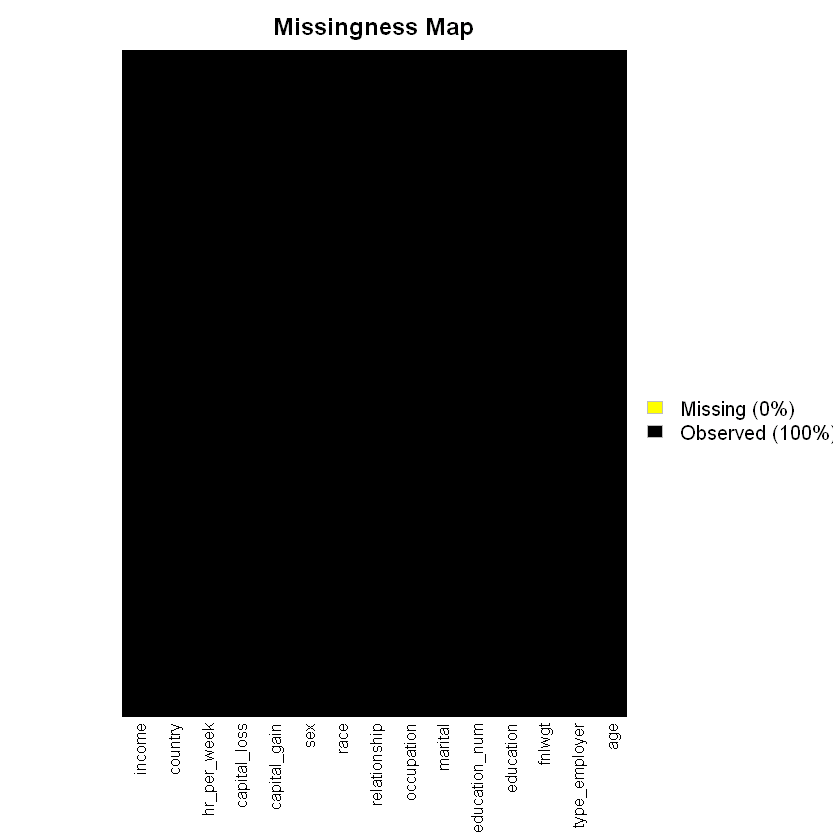

In [56]:
adult <- na.omit(adult)
str(adult)
missmap(adult, y.at=c(1), y.labels=c(''), col = c('yellow','black'))

## Exploratory Data Analysis

In [57]:
str(adult)

'data.frame':	30718 obs. of  15 variables:
 $ age          : int  39 50 38 53 28 37 49 52 31 42 ...
 $ type_employer: Factor w/ 5 levels "Federal-gov",..: 4 3 2 2 2 2 2 3 2 2 ...
 $ fnlwgt       : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education    : Factor w/ 16 levels "10th","11th",..: 10 10 12 2 10 13 7 12 13 10 ...
 $ education_num: int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital      : Factor w/ 3 levels "Married","Never-Married",..: 2 1 3 1 1 1 1 1 2 1 ...
 $ occupation   : Factor w/ 14 levels "Adm-clerical",..: 1 4 6 6 10 4 8 4 10 4 ...
 $ relationship : Factor w/ 6 levels "Husband","Not-in-family",..: 2 1 2 1 6 6 2 1 2 1 ...
 $ race         : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 5 3 3 5 3 5 5 5 ...
 $ sex          : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 1 1 2 1 2 ...
 $ capital_gain : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hr_per_week  : int  40 13 40 40 40 40 16 45 50 40 

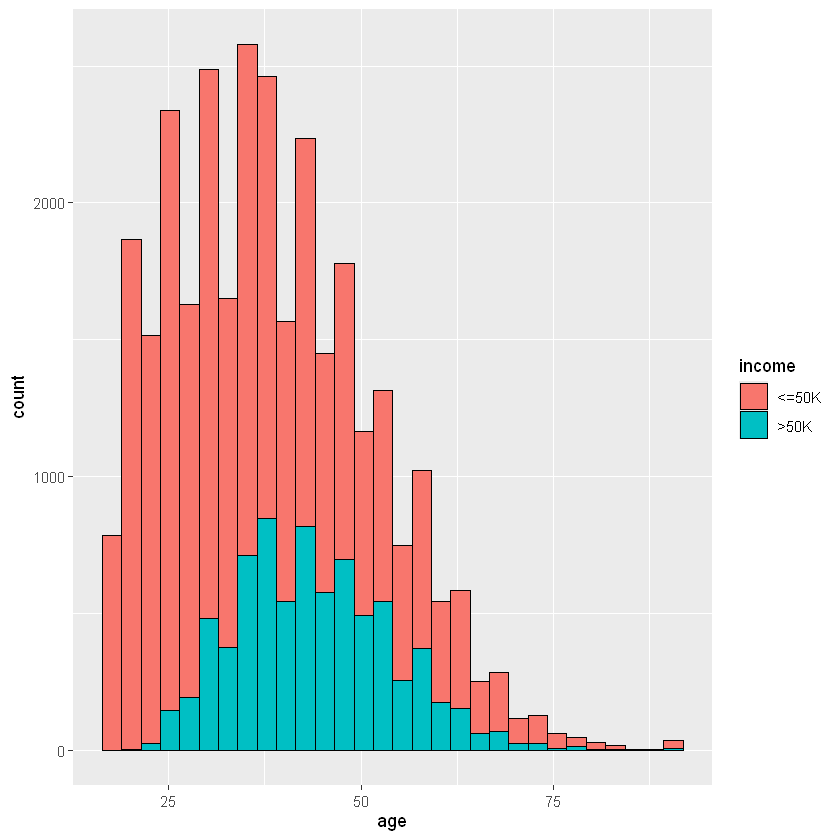

In [58]:
# Histogram of Age colored by income
library(ggplot2)
pl <- ggplot(adult, aes(age, fill= income)) + geom_histogram(color='black', bins=30, position = "stack")
pl

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


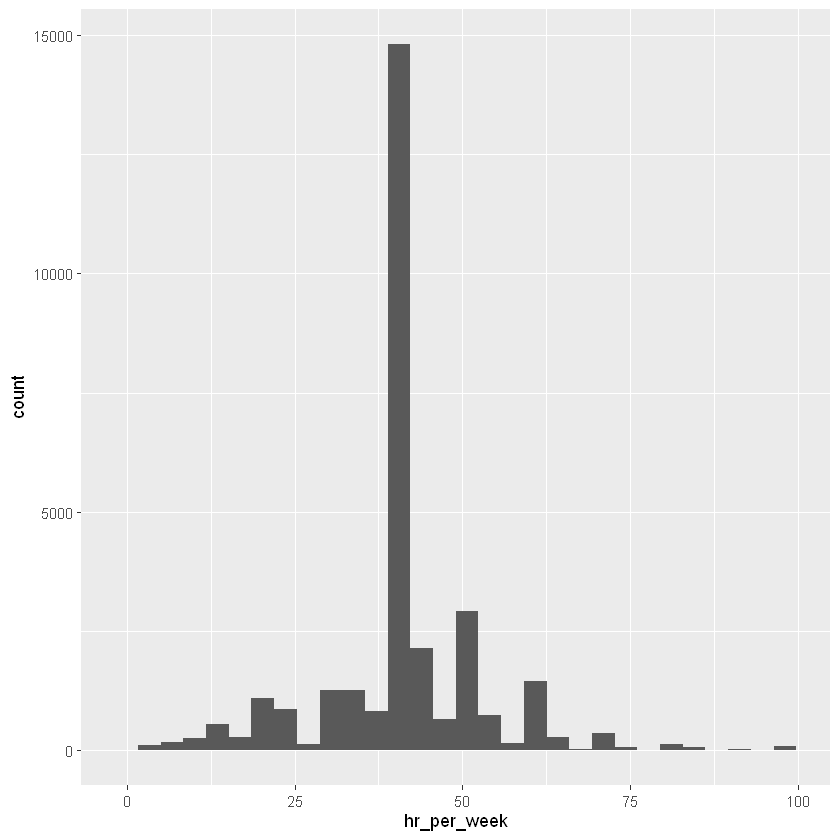

In [59]:
# Histogram of hours worked per week
pl2 <- ggplot(adult, aes(hr_per_week)) + geom_histogram()
pl2

In [60]:
# Rename country to region
adult <- adult %>% rename( 'region' = country)

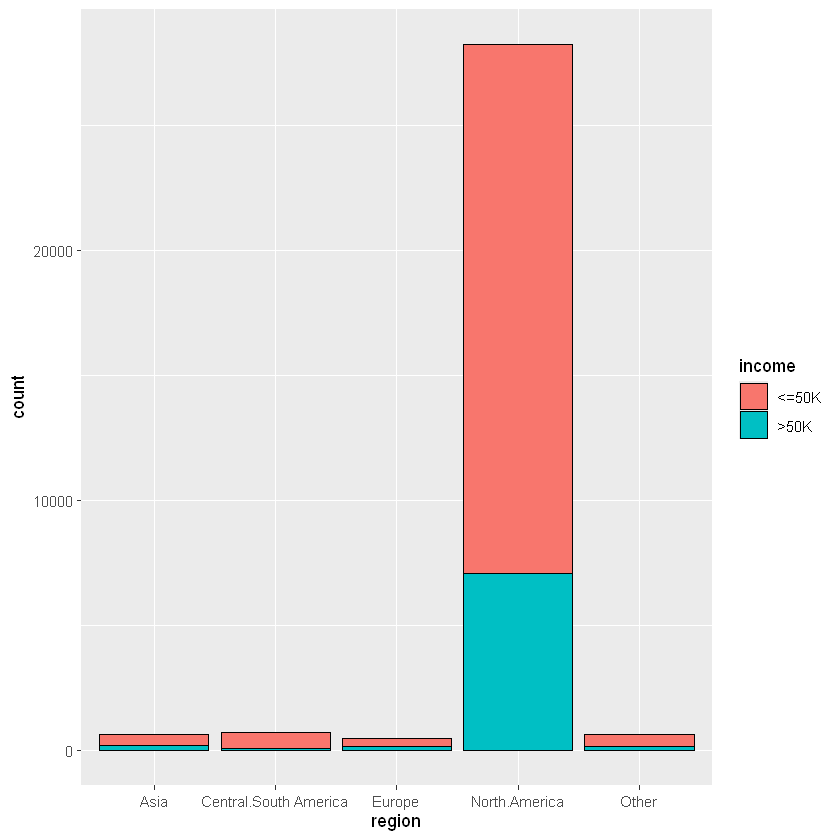

In [61]:
pl3 <- ggplot(adult, aes(x=region, fill=income,)) +geom_bar( color='black')
pl3

## Logistic Regression Modeling

In [62]:
head(adult)

,age,type_employer,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,region,income
,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
1,39,SL-gov,77516,Bachelors,13,Never-Married,Adm-clerical,Not-in-family,White,Male,2174,0,40,North.America,<=50K
2,50,self-emp,83311,Bachelors,13,Married,Exec-managerial,Husband,White,Male,0,0,13,North.America,<=50K
3,38,Private,215646,HS-grad,9,Not-Married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,North.America,<=50K
4,53,Private,234721,11th,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,North.America,<=50K
5,28,Private,338409,Bachelors,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,Central.South America,<=50K
6,37,Private,284582,Masters,14,Married,Exec-managerial,Wife,White,Female,0,0,40,North.America,<=50K


In [64]:
library(caTools)
set.seed(101)
split <- sample.split(adult$income, SplitRatio = 0.7 )
train <- subset(adult, split==T)
test <- subset(adult, split==F)

log.model <- glm(income ~ ., family = binomial(link='logit'),data = train )

summary(log.model)


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = income ~ ., family = binomial(link = "logit"), 
    data = train)

Coefficients: (1 not defined because of singularities)
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -5.471e+00  4.345e-01 -12.592  < 2e-16 ***
age                          2.558e-02  2.005e-03  12.760  < 2e-16 ***
type_employerPrivate        -4.524e-01  1.126e-01  -4.019 5.86e-05 ***
type_employerself-emp       -6.823e-01  1.244e-01  -5.483 4.19e-08 ***
type_employerSL-gov         -6.891e-01  1.267e-01  -5.441 5.31e-08 ***
type_employerUnemployed     -1.414e+01  3.684e+02  -0.038 0.969374    
fnlwgt                       4.907e-07  2.075e-07   2.365 0.018020 *  
education11th                2.020e-01  2.569e-01   0.786 0.431590    
education12th                3.790e-01  3.406e-01   1.113 0.265791    
education1st-4th            -6.877e-01  5.975e-01  -1.151 0.249742    
education5th-6th            -2.474e-01  3.919e-01  -0.631 0.527890    
educa

In [ ]:
new.step.model <- step(log.model)

In [ ]:
summary(new.step.model)

## Prediction

In [74]:
# prediction with test

test$predicted.income <- predict(log.model, newdata = test, type='response')

table(test$income, test$predicted.income > 0.5)
acc <- (6369+1420)/(6369+1420+551+875)
recall <- 6369/(6369+551)
precision <- 6369/(6369+875)
print(acc)
print(recall)
print(precision)

       
        FALSE TRUE
  <=50K  6369  551
  >50K    875 1420

[1] 0.8452523
[1] 0.9203757
[1] 0.8792104


* Given the information, there's no real way to get a correct evaluation of how good this model is.
* cost associated with the metrics is needed to decide whether or not we use this model.